In [1]:
import matplotlib
matplotlib.use('TkAgg')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('max_column', 100)

In [2]:
mst_path = '/Users/amywatt1/Desktop/bikes/BikeSGV/datasets/mst/'
fig_path = '/Users/amywatt1/Desktop/bikes//BikeSGV/export/02_summary_stats_ped/'

In [3]:
df = pd.read_csv(mst_path + 'clean_bike.csv')
df.head()

,intervalid,location_id,street1,street2,street3,latitude,longitude,date,weekday,period_begin,period_end,interval_begin,ns,sn,ew,we,female,sidewalk,wrongway,count_method,count_bikesonsidewalks,raining,unusual,bikewaytype,bikewaytype_options,road_class,speed_limit,landuse,pk_dataset_id,city,createdatetime,total_count,no_helmet,child
0,19203.0,1025.0,Durfee Ave.,Santa Anita Ave.,Peck Rd.,34.035943,-118.039993,12-03-2016,Saturday,11:00 AM,1:00 AM,11:00 AM,0,0,0,1,0,0,1.0,manual_in_house,1,no,none,none,none,minorArterial,40.0,neighborhoodRetail,133.0,SEM,2017-07-17 15:08:00,1,1,0
1,19204.0,1025.0,Durfee Ave.,Santa Anita Ave.,Peck Rd.,34.035943,-118.039993,12-03-2016,Saturday,11:00 AM,1:00 AM,11:15 AM,0,0,1,0,0,0,0.0,manual_in_house,1,no,none,none,none,minorArterial,40.0,neighborhoodRetail,133.0,SEM,2017-07-17 15:08:00,1,0,0
2,19205.0,1025.0,Durfee Ave.,Santa Anita Ave.,Peck Rd.,34.035943,-118.039993,12-03-2016,Saturday,11:00 AM,1:00 AM,11:30 AM,0,0,1,0,0,0,0.0,manual_in_house,1,no,none,none,none,minorArterial,40.0,neighborhoodRetail,133.0,SEM,2017-07-17 15:08:00,1,0,0
3,19206.0,1025.0,Durfee Ave.,Santa Anita Ave.,Peck Rd.,34.035943,-118.039993,12-03-2016,Saturday,11:00 AM,1:00 AM,11:45 AM,0,0,2,0,0,0,0.0,manual_in_house,1,no,none,none,none,minorArterial,40.0,neighborhoodRetail,133.0,SEM,2017-07-17 15:08:00,2,0,0
4,19207.0,1025.0,Durfee Ave.,Santa Anita Ave.,Peck Rd.,34.035943,-118.039993,12-03-2016,Saturday,11:00 AM,1:00 AM,12:00 PM,0,0,0,0,0,0,0.0,manual_in_house,1,no,none,none,none,minorArterial,40.0,neighborhoodRetail,133.0,SEM,2017-07-17 15:08:00,0,0,0


# Identify problems with `date` and its distribution

Explore the data types of each column. Notice that the time column "date" is of type "object". Let's change that to datetime 

In [4]:
df.dtypes['date']

dtype('O')

In [5]:
df['date'] = pd.to_datetime(df['date'])
df.dtypes['date']

dtype('<M8[ns]')

In [6]:
# Observe that there are some nan values in the column date. We drop these rows
print("Number of nans in the date column:", df.isnull().sum()['date'])
df = df.dropna(subset = ['date'])
df.index = range(len(df))
df.shape

Number of nans in the date column: 16


(2608, 34)

In [7]:
# Explore the number of observations per year_month combinatino for the dataset
df['month'] = df['date'].apply(lambda x: x.month)
df['year'] = df['date'].apply(lambda x: int(x.year))
df['yr_mo'] = [str(a)+'-'+str(b) for a,b in zip(df['year'], df['month'])]
df['yr_mo'].value_counts()

2017-4     528
2017-6     280
2017-5     256
2016-4     240
2016-12    208
2016-5     208
2016-10    184
2017-1     144
2017-3     136
2017-2     120
2016-11    112
2017-7      56
2016-9      56
2018-1      24
2016-8      24
2018-7      24
2017-8       8
Name: yr_mo, dtype: int64

It seems that 2017-01 to 2017-06 has most of the data points, so we focus on this period only. Note that you can totally make other assumptions and subset the data in another way! This is just what I am doing here.

In [8]:
# Subset the data for only this time range:
time_range = ['2017-' + str(i) for i in range(1,7)]
print("time_range", time_range)

# Subset the data and check how many obs. are left
df = df[df['yr_mo'].isin(time_range)]
df.shape

time_range ['2017-1', '2017-2', '2017-3', '2017-4', '2017-5', '2017-6']


(1464, 37)

# Temporal Trend of Total Counts

In order to explore any trends, we need to aggregate the data somehow. For example, assume we want to group by `date` and find the `sum` and `mean` of the variable `total_count` on each day, we could use the `groupby` and `agg` functions to achieve this.

Also try play around with 
```
grouped = df.groupby('date').agg(['sum', 'mean']).reset_index()
grouped.head()
```

In [9]:
grouped = df.groupby(['date', 'weekday']).agg(['sum', 'mean'])['total_count'].reset_index()
grouped.head()


,date,weekday,sum,mean
0,2017-01-10,Tuesday,3,0.1875
1,2017-01-15,Sunday,43,2.6875
2,2017-01-17,Tuesday,28,1.7500
3,2017-01-24,Tuesday,20,1.2500
4,2017-01-26,Thursday,17,2.1250


Let's try plotting the average total count per day. Note that this doesn't tell us anything useful, as we did not take into account the number of volunteers availabe!! Try deleting or adding back the last few functions (`plt.xticks`, `plt.xlabel`) and observe the difference. 

Text(0.5, 1.0, 'Average total_count by date')

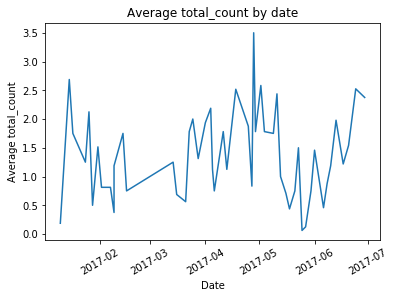

In [10]:
%matplotlib inline
plt.plot(grouped['date'], grouped['mean'])
plt.xticks(rotation = 30)
plt.xlabel('Date')
plt.ylabel('Average total_count')
plt.title("Average total_count by date")

Assume we only want to look at two cities, we could subset the datasets and do the same thing as above. Note that the below commands examines the two cities with most number of observations.

In [11]:
# Find which cities has most number of observations
cities = df['city'].value_counts().sort_values(ascending = False)
cities

Duarte                     176
Altadena                   144
Arcadia                    120
Mt. SAC/Cal Poly/Walnut    120
Pomona                     104
Rowland Heights             88
La Puente                   80
Baldwin Park                72
Temple City                 72
E. Pasadena                 72
La Verne                    64
Covina                      64
SEM                         56
Hacienda Height             48
Azusa                       40
Claremont                   32
S. Pasadena                 24
San Diamas                  24
Irwindale                   16
Pasadena                     8
West Covina                  8
Name: city, dtype: int64

In [12]:
# Extract the two top cities:
top_cities = cities.index[:2]
top_cities

Index(['Duarte', 'Altadena'], dtype='object')

In [13]:
# We will proceed with Glendora and SEM
gle = df[df['city'] == 'Glendora']
sem = df[df['city'] == 'SEM']
print(gle.shape)
print(sem.shape)

(0, 37)
(56, 37)


In [14]:
# Perform the same groupby commands
gle_group = gle.groupby('date').agg(['sum', 'mean'])['total_count'].reset_index()
sem_group = sem.groupby('date').agg(['sum', 'mean'])['total_count'].reset_index()
sem_group.dtypes[:]

date    datetime64[ns]
sum              int64
mean           float64
dtype: object

Text(0.5, 1.0, 'Average total_count by date')

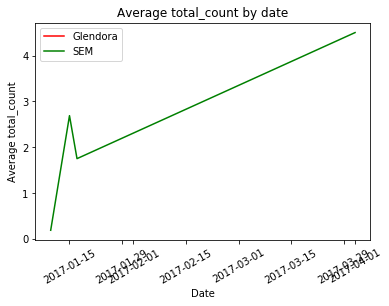

In [15]:
# Do the same time plot
%matplotlib inline
plt.plot(gle_group['date'], gle_group['mean'], color = 'red', label = 'Glendora')
plt.plot(sem_group['date'], sem_group['mean'], color = 'green', label = 'SEM')
plt.xticks(rotation = 30)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Average total_count')
plt.title("Average total_count by date")

Gotta say this looks pretty bad... Now try select cities with most number of dates

In [16]:
city_ndate = df.groupby('city')['date'].nunique().sort_values(ascending = False)
city_ndate.head()

city
Duarte                     13
Altadena                   12
Mt. SAC/Cal Poly/Walnut     8
Arcadia                     7
Rowland Heights             7
Name: date, dtype: int64

Now you could perform the same analysis as above on these cities. I will not repeat that again.

In [17]:
# Extract the two top cities:
top_cities_ndate = city_ndate[:2]
top_cities_ndate

city
Duarte      13
Altadena    12
Name: date, dtype: int64

In [18]:
# We will proceed with Altadena and Duarte

alt = df[df['city'] == 'Altadena']
dua = df[df['city'] == 'Duarte']
print(alt.shape)

# Perform the same groupby commands
alt_group = alt.groupby('date').agg(['sum', 'mean'])['total_count'].reset_index()
dua_group = dua.groupby('date').agg(['sum', 'mean'])['total_count'].reset_index()
dua_group.dtypes[:]

(144, 37)


date    datetime64[ns]
sum              int64
mean           float64
dtype: object

Text(0.5, 1.0, 'Average total_count by date')

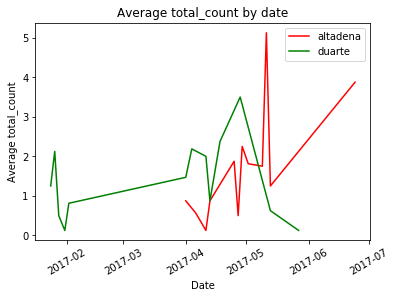

In [19]:
# Do the same time plot
%matplotlib inline
plt.plot(alt_group['date'], alt_group['mean'], color = 'red', label = 'altadena')
plt.plot(dua_group['date'], dua_group['mean'], color = 'green', label = 'duarte')
plt.xticks(rotation = 30)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Average total_count')
plt.title("Average total_count by date")

# Temporal Trends of One Variable

In [20]:
# Create two time series - female and total
female = df.groupby('date').agg(['sum'])['female'].reset_index()
total = df.groupby('date').agg(['sum'])['total_count'].reset_index()
print(female.shape)
print(total.shape)

female.head()

(50, 2)
(50, 2)


,date,sum
0,2017-01-10,0
1,2017-01-15,4
2,2017-01-17,2
3,2017-01-24,1
4,2017-01-26,2


In [21]:
# We change the columns and merge these two datasets together
female.columns = ['date', 'female']
total.columns = ['date', 'total_count']

merged = pd.merge(female, total, on = 'date', how = 'inner')
merged.shape

(50, 3)

In [22]:
merged.head()

,date,female,total_count
0,2017-01-10,0,3
1,2017-01-15,4,43
2,2017-01-17,2,28
3,2017-01-24,1,20
4,2017-01-26,2,17


In [23]:
# Explore female percentage changes - create a new column called female_perc
merged['female_perc'] = merged['female'] / merged['total_count']
merged.head()

,date,female,total_count,female_perc
0,2017-01-10,0,3,0.000000
1,2017-01-15,4,43,0.093023
2,2017-01-17,2,28,0.071429
3,2017-01-24,1,20,0.050000
4,2017-01-26,2,17,0.117647


Text(0, 0.5, 'Female Percentage')

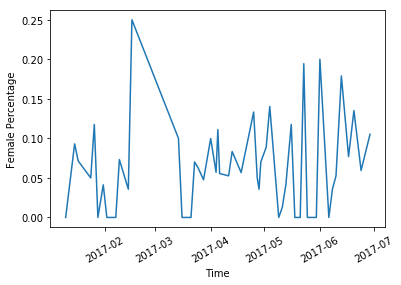

In [24]:
# Naive time plot
%matplotlib inline
plt.plot(merged['date'], merged['female_perc'])
plt.xticks(rotation = 30)
plt.xlabel('Time')
plt.ylabel('Female Percentage')

## Notice that the curve remained 0 for a long time, this is probably that the female data is not collected on this time period.

In [25]:
df.head()

,intervalid,location_id,street1,street2,street3,latitude,longitude,date,weekday,period_begin,period_end,interval_begin,ns,sn,ew,we,female,sidewalk,wrongway,count_method,count_bikesonsidewalks,raining,unusual,bikewaytype,bikewaytype_options,road_class,speed_limit,landuse,pk_dataset_id,city,createdatetime,total_count,no_helmet,child,month,year,yr_mo
32,18082.0,1030.0,Durfee Ave.,Thienes Ave.,Rush St.,34.043525,-118.032415,2017-01-17,Tuesday,7:00 AM,9:00 AM,7:00 AM,1,3,0,0,1,2,0.0,manual_in_house,1,no,none,none,none,principalArterial,35.0,neighborhoodRetail,133.0,SEM,2017-02-07 13:27:00,4,4,0,1,2017,2017-1
33,18083.0,1030.0,Durfee Ave.,Thienes Ave.,Rush St.,34.043525,-118.032415,2017-01-17,Tuesday,7:00 AM,9:00 AM,7:15 AM,1,1,0,0,0,2,0.0,manual_in_house,1,no,none,none,none,principalArterial,35.0,neighborhoodRetail,133.0,SEM,2017-02-07 13:27:00,2,2,0,1,2017,2017-1
34,18084.0,1030.0,Durfee Ave.,Thienes Ave.,Rush St.,34.043525,-118.032415,2017-01-17,Tuesday,7:00 AM,9:00 AM,7:30 AM,0,1,0,0,0,1,0.0,manual_in_house,1,no,none,none,none,principalArterial,35.0,neighborhoodRetail,133.0,SEM,2017-02-07 13:27:00,1,1,0,1,2017,2017-1
35,18085.0,1030.0,Durfee Ave.,Thienes Ave.,Rush St.,34.043525,-118.032415,2017-01-17,Tuesday,7:00 AM,9:00 AM,7:45 AM,0,1,0,0,0,1,0.0,manual_in_house,1,no,none,none,none,principalArterial,35.0,neighborhoodRetail,133.0,SEM,2017-02-07 13:27:00,1,1,0,1,2017,2017-1
36,18086.0,1030.0,Durfee Ave.,Thienes Ave.,Rush St.,34.043525,-118.032415,2017-01-17,Tuesday,7:00 AM,9:00 AM,8:00 AM,0,0,0,0,0,0,0.0,manual_in_house,1,no,none,none,none,principalArterial,35.0,neighborhoodRetail,133.0,SEM,2017-02-07 13:27:00,0,0,0,1,2017,2017-1


In [26]:
#trends for different weekdays to see if bike activity is lower on weekend vs weekday
weekday = df.groupby(['city', 'weekday']).agg(['sum', 'mean', 'count'])['total_count'].reset_index()
weekday.head()

,city,weekday,sum,mean,count
0,Altadena,Saturday,80,1.666667,48
1,Altadena,Thursday,70,1.250000,56
2,Altadena,Tuesday,59,1.475000,40
3,Arcadia,Saturday,134,3.350000,40
4,Arcadia,Thursday,31,1.291667,24


In [27]:
#drop any rows with fewer than 25 observations
weekday = weekday.loc[weekday['count'] > 23]
weekday.dtypes[:]

city        object
weekday     object
sum          int64
mean       float64
count        int64
dtype: object

In [28]:
cities_dict = {}
cities = []
for city in weekday["city"]:
    if city in cities_dict.keys():
        cities_dict[city] = cities_dict[city] + 1
    else:
        cities_dict[city] = 1
        
for key in cities_dict.keys():
    if cities_dict[key] == 3:
        cities.append(key)

print (cities)


['Arcadia', 'Rowland Heights', 'Duarte', 'Pomona', 'Altadena']


Text(0.5, 1.0, 'Average Total Count by Day of Week')

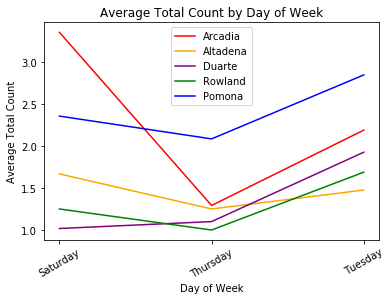

In [29]:
Arcadia = weekday.loc[weekday['city'] == 'Arcadia']
Altadena = weekday.loc[weekday['city'] == 'Altadena']
Duarte = weekday.loc[weekday['city'] == 'Duarte']
Rowland = weekday.loc[weekday['city'] == 'Rowland Heights']
Pomona = weekday.loc[weekday['city'] == 'Pomona']

%matplotlib inline
plt.plot(Arcadia['weekday'], Arcadia['mean'], color = 'red', label = 'Arcadia')
plt.plot(Altadena['weekday'], Altadena['mean'], color = 'orange', label = 'Altadena')
plt.plot(Duarte['weekday'], Duarte['mean'], color = 'purple', label = 'Duarte')
plt.plot(Rowland['weekday'], Rowland['mean'], color = 'green', label = 'Rowland')
plt.plot(Pomona['weekday'], Pomona['mean'], color = 'blue', label = 'Pomona')
plt.xticks(rotation = 30)
plt.legend()
plt.xlabel('Day of Week')
plt.ylabel('Average Total Count')
plt.title("Average Total Count by Day of Week")

In [48]:
#trends for different time periods
city = df.groupby(['city', 'period_begin', 'period_end']).agg(['sum', 'mean', 'count'])['total_count'].reset_index()
city = city.loc[city['count'] > 23]
city.head()

,city,period_begin,period_end,sum,mean,count
0,Altadena,11:00 AM,1:00 PM,78,1.625000,48
1,Altadena,4:00 PM,6:00 PM,70,1.458333,48
2,Altadena,7:00 AM,9:00 AM,61,1.270833,48
3,Arcadia,11:00 AM,1:00 PM,134,3.350000,40
4,Arcadia,4:00 PM,6:00 PM,89,2.225000,40


In [37]:
cities_dict = {}
cities = []
for c in city["city"]:
    if c in cities_dict.keys():
        cities_dict[c] = cities_dict[c] + 1
    else:
        cities_dict[c] = 1
        
for key in cities_dict.keys():
    if cities_dict[key] == 3:
        cities.append(key)

print (cities)

['Arcadia', 'Baldwin Park', 'Rowland Heights', 'Duarte', 'Mt. SAC/Cal Poly/Walnut', 'Altadena', 'Temple City', 'Pomona', 'E. Pasadena']


Text(0.5, 1.0, 'Average Total Count by Time Period')

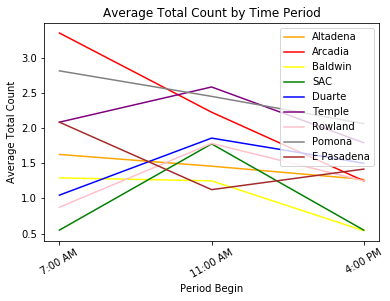

In [47]:
Arcadia = city.loc[city['city'] == 'Arcadia']
Altadena = city.loc[city['city'] == 'Altadena']
Baldwin = city.loc[city['city'] == 'Baldwin Park']
SAC = city.loc[city['city'] == 'Mt. SAC/Cal Poly/Walnut']
Duarte = city.loc[city['city'] == 'Duarte']
Temple = city.loc[city['city'] == 'Temple City']
Rowland = city.loc[city['city'] == 'Rowland Heights']
Pomona = city.loc[city['city'] == 'Pomona']
EPasadena = city.loc[city['city'] == 'E. Pasadena']

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
xt = ['7:00 AM', '11:00 AM', '4:00 PM']
ax.set_xticklabels(xt)

plt.plot(Altadena['period_begin'], Altadena['mean'], color = 'orange', label = 'Altadena')
plt.plot(Arcadia['period_begin'], Arcadia['mean'], color = 'red', label = 'Arcadia')
plt.plot(Baldwin['period_begin'], Baldwin['mean'], color = 'yellow', label = 'Baldwin')
plt.plot(SAC['period_begin'], SAC['mean'], color = 'green', label = 'SAC')
plt.plot(Duarte['period_begin'], Duarte['mean'], color = 'blue', label = 'Duarte')
plt.plot(Temple['period_begin'], Temple['mean'], color = 'purple', label = 'Temple')
plt.plot(Rowland['period_begin'], Rowland['mean'], color = 'pink', label = 'Rowland')
plt.plot(Pomona['period_begin'], Pomona['mean'], color = 'grey', label = 'Pomona')
plt.plot(EPasadena['period_begin'], EPasadena['mean'], color = 'brown', label = 'E Pasadena')
plt.xticks(rotation = 30)
plt.legend()
plt.xlabel('Period Begin')
plt.ylabel('Average Total Count')
plt.title("Average Total Count by Time Period")

In [33]:
#locations with the highest number of average bikers passing through
location = df.groupby(['location_id', 'city']).agg(['sum', 'mean', 'count'])['total_count'].reset_index()
location = location.sort_values('mean', ascending = False)
location.head()

,location_id,city,sum,mean,count
5,1545.0,SEM,36,4.500000,8
37,1607.0,Pasadena,36,4.500000,8
31,1600.0,Arcadia,98,4.083333,24
52,1620.0,Azusa,88,3.666667,24
30,1599.0,Arcadia,77,3.208333,24


In [84]:
cities_dict = {}
for c in location["city"][:20]:
    if c in cities_dict.keys():
        cities_dict[c] = cities_dict[c] + 1
    else:
        cities_dict[c] = 1
#s_cities = sorted(cities_dict.items(), key=lambda x: x[1], reverse=True)

#for k, v in s_cities:
#    print(k, v)
cities_dict

{'Altadena': 2,
 'Arcadia': 2,
 'Azusa': 1,
 'Duarte': 2,
 'La Verne': 1,
 'Pasadena': 1,
 'Pomona': 4,
 'Rowland Heights': 2,
 'SEM': 2,
 'Temple City': 3}

In [85]:
all_cities_dict_temp = {}
for c in location["city"]:
    if c in all_cities_dict_temp.keys():
        all_cities_dict_temp[c] = all_cities_dict_temp[c] + 1
    else:
        all_cities_dict_temp[c] = 1
        
all_cities_dict = {}
for entry in all_cities_dict_temp:
    if entry in cities_dict.keys():
        all_cities_dict[entry] = all_cities_dict_temp[entry]
    
#s_all_cities = sorted(all_cities_dict.items(), key=lambda x: x[1], reverse=True)

#for k, v in s_all_cities:
#    print(k, v)
all_cities_dict

{'Altadena': 6,
 'Arcadia': 5,
 'Azusa': 2,
 'Duarte': 8,
 'La Verne': 3,
 'Pasadena': 1,
 'Pomona': 5,
 'Rowland Heights': 4,
 'SEM': 4,
 'Temple City': 3}

In [104]:
cities_perc_dict = {}

for key in cities_dict:
    cities_perc_dict[key] = cities_dict[key]/all_cities_dict[key]
#s_perc = sorted(cities_perc_dict.items(), key=lambda x: x[1], reverse=True)

c = []
perc = []
num_locations = []
top_20 = []
not_top_20 = []
for key in cities_perc_dict:
    c.append(key)
    perc.append(cities_perc_dict[key])
    num_locations.append(all_cities_dict[key])
    top_20.append(cities_dict[key])
    not_top_20.append(all_cities_dict[key]-cities_dict[key])

In [105]:
d = {'city': c, 'num locations': num_locations, 'top 20': top_20, 'not top 20':not_top_20, 'perc':perc}
df = pd.DataFrame(data=d)
df

,city,not top 20,num locations,perc,top 20
0,SEM,2,4,0.500000,2
1,Azusa,1,2,0.500000,1
2,Pasadena,0,1,1.000000,1
3,Temple City,0,3,1.000000,3
4,Pomona,1,5,0.800000,4
5,Arcadia,3,5,0.400000,2
6,Altadena,4,6,0.333333,2
7,La Verne,2,3,0.333333,1
8,Rowland Heights,2,4,0.500000,2
9,Duarte,6,8,0.250000,2


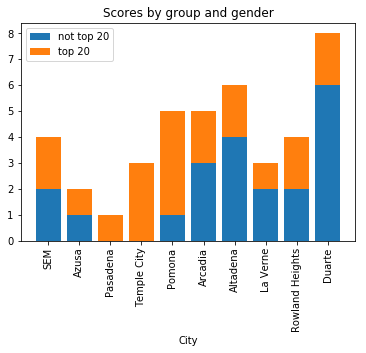

In [114]:
p1 = plt.bar(df["city"], df["not top 20"])
p2 = plt.bar(df["city"], df["top 20"], bottom = df["not top 20"])
plt.xlabel('City')
plt.ylabel('Number o')
plt.xticks(rotation = 90)
plt.title('Scores by group and gender')
plt.legend((p1[0], p2[0]), ('not top 20', 'top 20'))

plt.show()